# Analysis of Calendar Table — Inside Airbnb Santiago

## 1. Introduction

The calendar table contains daily availability and pricing information for each Airbnb listing in Santiago.  
Analyzing this table helps understand booking patterns, seasonal trends, and pricing fluctuations over time.

## 2. Load and Preview
In this section, we will load the calendar dataset, examine its dimensions and structure, and perform an initial check for missing values. Specifically, we will:

- Load the dataset from the local folder.
- Display the shape and data types of the dataframe.
- Show a preview of the first few rows.
- Summarize missing values by column.

In [37]:
import pandas as pd

# Load the calendar data from a gzipped CSV file
df_calendar = pd.read_csv('santiago/calendar.csv.gz', compression='gzip') 


# Preview the data
print("\n----Preview:\n")
display(df_calendar.head())

print("\n----Info:\n")
df_calendar.info()

print("\n----Shape:\n")
print(df_calendar.shape)

# Check for missing values
print("\n----Missing Values:\n")
print(df_calendar.isnull().sum())


----Preview:



,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,49392,2024-12-27,f,$55.00,NaN,3,730
1,49392,2024-12-28,f,$55.00,NaN,3,730
2,49392,2024-12-29,t,$55.00,NaN,3,730
3,49392,2024-12-30,t,$55.00,NaN,3,730
4,49392,2024-12-31,t,$55.00,NaN,3,730



----Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5493615 entries, 0 to 5493614
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  float64
 5   minimum_nights  int64  
 6   maximum_nights  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 293.4+ MB

----Shape:

(5493615, 7)

----Missing Values:

listing_id              0
date                    0
available               0
price                   0
adjusted_price    5493615
minimum_nights          0
maximum_nights          0
dtype: int64


#### Observations

- The calendar table contains 5,493,615 rows and 7 columns.  

- Columns include listing ID, date, price, availability, and more. 

- The price column is in Chilean Pesos (CLP). To facilitate comparison and analysis, I will add a new column `price_usd`

- Several columns are incorrectly typed as `object` and will be converted to the appropriate types during cleaning.

- The `adjusted_price` column contains only null values and will be dropped during cleaning.  

- Aside from this, no other columns contain missing values.


## 3. Cleaning

In this section, I will clean the calendar dataset by:

- Dropping irrelevant columns.
- Converting data types to appropriate formats.
- Handling missing values.
- Adding `price_usd` column.
- Renaming columns for clarity and consistency

### 3.1 Drop irrelevant columns and handle missing values

The `adjusted_price` column contains only null values, so it provides no useful information and will be dropped from the dataset. Since no other columns have missing values, no further imputation is required at this stage.



In [38]:
# Drop the 'adjusted_price' column
df_calendar.drop(columns=['adjusted_price'], inplace=True)

### 3.2 Convert data types

- The `date` column is stored as a string but should be converted to a `datetime` type for proper time-series analysis. 

- The `price` column is stored as a string and contains currency symbols, which must be cleaned and converted to numeric values for quantitative analysis.  

- The `available` column is currently represented as `'t'` and `'f'` strings. I will map these to boolean `True` and `False` values to facilitate logical operations and analyses.  



In [39]:
# Convert 'date' column from string to datetime format
df_calendar['date'] = pd.to_datetime(df_calendar['date'], format='%Y-%m-%d')

# Clean 'price' column by removing '$' and ',' then convert to float
df_calendar['price'] = df_calendar['price'].replace({r'\$': '', r',': ''}, regex=True).astype(float)

# Map 'available' column values from 't'/'f' strings to boolean True/False
df_calendar['available'] = df_calendar['available'].map({'t': True, 'f': False}).astype('boolean')

# Check the updated DataFrame
df_calendar.dtypes


listing_id                 int64
date              datetime64[ns]
available                boolean
price                    float64
minimum_nights             int64
maximum_nights             int64
dtype: object

### 3.3 Rename columns

To improve clarity and consistency in naming:

- `price` → `price_clp`: reflects that the original price is in Chilean Pesos

- `available` → `is_available`: uses a boolean-style naming convention for clarity

In [40]:
# Rename columns for clarity
df_calendar.rename(columns={
     'available': 'is_available',
    'price': 'price_clp'
}, inplace=True)

### 3.4 Add calculated column
The price column is in Chilean Pesos (CLP). To facilitate comparison and analysis, I will add a new column price_usd by converting prices to US dollars using an approximate exchange rate of 1 CLP = 0.0011 USD.

In [41]:
# Define exchange rate
exchange_rate = 0.0011

# Calculate price in USD
price_usd = (df_calendar['price_clp'] * exchange_rate).round(2)

# Insert 'price_usd' column right after 'price_clp'
price_clp_index = df_calendar.columns.get_loc('price_clp')
df_calendar.insert(price_clp_index + 1, 'price_usd', price_usd)

# Preview the cleaned DataFrame
print("\n----Cleaned DataFrame:\n")
display(df_calendar.head())


----Cleaned DataFrame:



,listing_id,date,is_available,price_clp,price_usd,minimum_nights,maximum_nights
0,49392,2024-12-27,False,55.0,0.06,3,730
1,49392,2024-12-28,False,55.0,0.06,3,730
2,49392,2024-12-29,True,55.0,0.06,3,730
3,49392,2024-12-30,True,55.0,0.06,3,730
4,49392,2024-12-31,True,55.0,0.06,3,730


In [ ]:
# Summary statistics for price
print(df_calendar['price'].describe())
print("99th percentile:", df_calendar['price'].quantile(0.99))



count    5.493615e+06
mean     7.161567e+04
std      9.178496e+05
min      1.100000e+01
25%      2.500000e+04
50%      3.803700e+04
75%      5.600000e+04
max      8.900000e+07
Name: price, dtype: float64
99th percentile: 450000.0


### Observations:

- Prices range from 11 CLP to 89 million CLP — extreme outliers are inflating the mean and standard deviation.
- The average price is about 71,616 CLP. This number is heavily affected by extreme values.
- 99% of listings are priced below 450,000 CLP.
- Most listings fall in the 25,000–56,000 CLP range.
- The lowest price found is 11 CLP— which seems unrealistic.

## Step 5: Visualizing Price Distribution

We'll plot a histogram of prices under 450,000 CLP (99% of the prices are below this amount) using a log scale to reveal patterns.


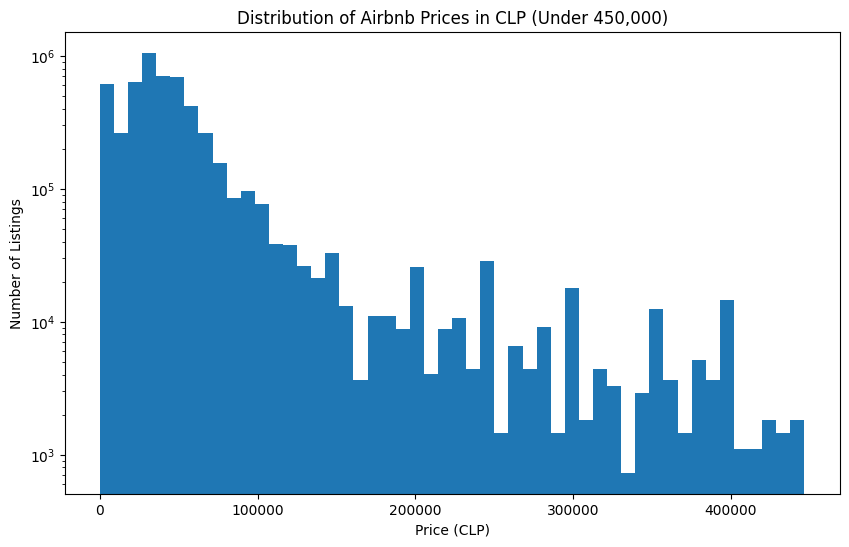

In [7]:
import matplotlib.pyplot as plt
import os

# Filter reasonable prices only
reasonable_prices = df_calendar[df_calendar['price'] < 450000]['price']

plt.figure(figsize=(10, 6))
plt.hist(reasonable_prices, bins=50)
plt.title("Distribution of Airbnb Prices in CLP (Under 450,000)")
plt.xlabel("Price (CLP)")
plt.ylabel("Number of Listings")
plt.yscale('log')  # Use logarithmic scale for better visibility

# Save the histogram as a PNG file in a directory 'figures'
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/price_distribution_u450.png', bbox_inches='tight')

plt.show()  # Show the plot after saving




## Step 6: Explore Low Price Listings

Now let’s inspect listings under 20,000 CLP and decide on a lower threshold.


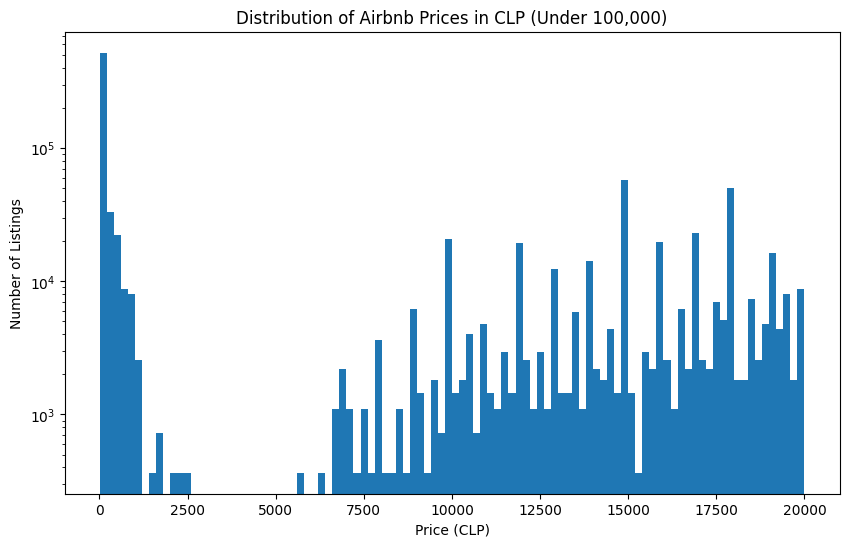

In [8]:
lower_prices = df_calendar[df_calendar['price'] < 20000]['price']

plt.figure(figsize=(10, 6))
plt.hist(lower_prices, bins=100)
plt.title("Distribution of Airbnb Prices in CLP (Under 100,000)")
plt.xlabel("Price (CLP)")
plt.ylabel("Number of Listings")
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.show()

### Decision:

Listings under 7,000 CLP (~7 USD) will be removed, as they are likely errors or irrelevant.


## Step 7: Final Transformations and Export

We'll now:
- Rename columns for clarity
- Add prices in USD
- Filter out extreme low/high values
- Save the clean dataset to disk


In [9]:
# Rename columns
df_calendar.rename(columns={'price': 'price_clp', 'available': 'is_available'}, inplace=True)

# Add price in USD
exchange_rate = 0.0011
df_calendar['price_usd'] = (df_calendar['price_clp'] * exchange_rate).round(2)

# Drop unused column
df_calendar.drop(columns=['adjusted_price'], inplace=True, errors='ignore')

# Filter out extreme values
df_calendar = df_calendar[
    (df_calendar['price_clp'] >= 7000) & 
    (df_calendar['price_clp'] <= 450000)
]

# Save cleaned data
import os
os.makedirs('cleaned_data', exist_ok=True)
df_calendar.to_csv('cleaned_data/calendar_cleaned.csv', index=False)


✅ The `calendar_cleaned.csv` file is now ready to be uploaded to Google Cloud for further analysis.
